In [2]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

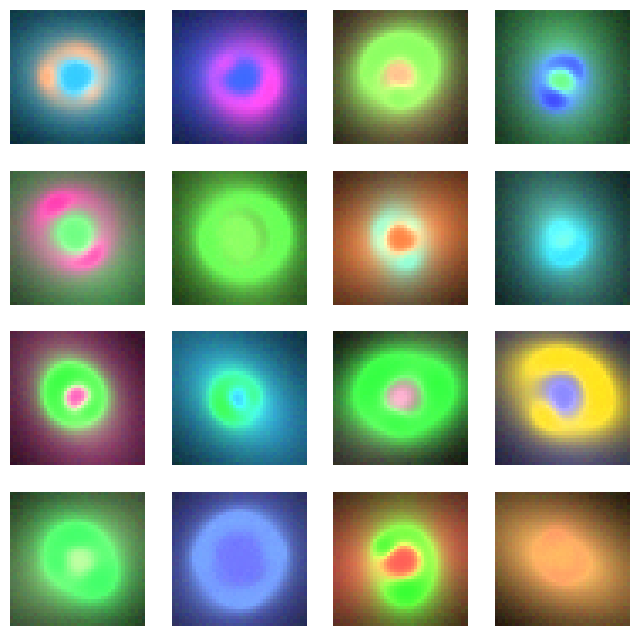

In [4]:
# Visualize source data
visualize_data(source_data)

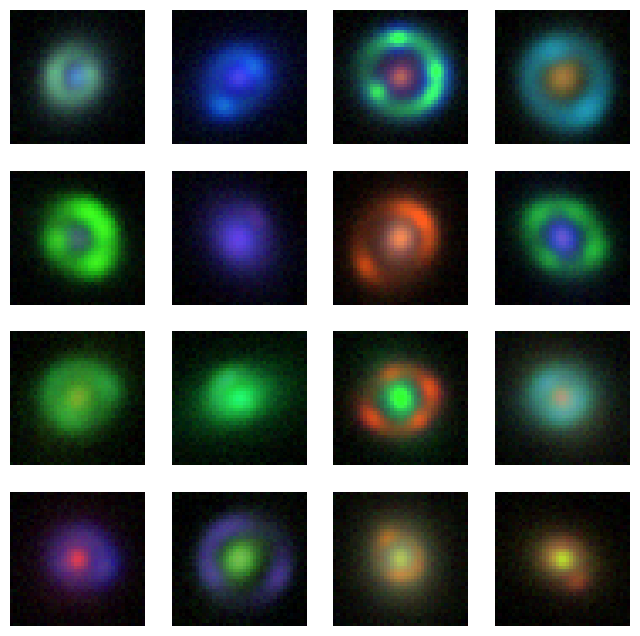

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# # Define and initialize model
# class NeuralNetworkMVEv2(nn.Module):
#     def __init__(self, npix):
#         super(NeuralNetworkMVEv2, self).__init__()
#         self.feature = nn.Sequential()
#         self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
#         self.feature.add_module('f_relu1', nn.ReLU(True))
#         self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
#         self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
#         self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
#         self.feature.add_module('f_relu2', nn.ReLU(True))
#         self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
#         self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
#         self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
#         self.feature.add_module('f_relu3', nn.ReLU(True))
#         self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
#         self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

#         self.regressor = nn.Sequential()
#         self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
#         self.regressor.add_module('f_relu1', nn.ReLU(True))
#         self.regressor.add_module('r_fc2', nn.Linear(in_features=128, out_features=32))
#         self.regressor.add_module('r_sig2', nn.Sigmoid())
#         self.regressor.add_module('r_fc3', nn.Linear(in_features=32, out_features=2))

#         self.npix = npix

#     def forward(self, x):
#         x = x.view(-1, 3, self.npix, self.npix)

#         features = self.feature(x)
#         features = features.view(-1, 32*5*5)
#         estimate = self.regressor(features)
#         estimate = F.relu(estimate)
#         estimate = estimate.view(-1, 2)

#         return estimate, features


#     def get_feature(self, x):
#         x = x.view(-1, 3, self.npix, self.npix)
#         features = self.feature(x)
#         features = features.view(-1, 32*5*5)
#         return features

In [7]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return 0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (2 * epoch / n_epoch)
    if ((epoch / n_epoch) > 0.5):
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 2e-5
n_epoch = 75
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.4

In [8]:
# Initialize model
#model = NeuralNetworkMVEv2(npix=40).cuda()
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
from torchsummary import summary

In [10]:
summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
          Sigmoid-14                  [

## Visualize Results

In [11]:
# Loads a model for plotting/viz

viz_mod_name = "models/mve_noDA_v2_aug7_1850"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [12]:
pd_stats = pd.DataFrame(stats)

In [13]:
pd_stats

,train_DA_loss,train_regression_loss,train_mve_loss,train_r2_score,val_source_regression_loss,val_target_regression_loss,val_source_r2_score,val_target_r2_score,val_source_mve_loss,val_target_mve_loss,da_weight,beta,epoch_no
0,0.482323,3.209984,1.461657,-8.863407,2.528743,2.512163,-6.747748,-6.827863,1.096271,1.088024,0,1.000,18
1,0.453402,1.886992,0.778321,-4.799637,1.413024,1.386670,-3.389414,-3.345138,0.541524,0.525467,0,0.996,18
2,0.433625,1.022398,0.349970,-2.132105,0.754605,0.731918,-1.316231,-1.269050,0.216855,0.201756,0,0.992,18
3,0.420231,0.565999,0.123364,-0.733587,0.450252,0.435867,-0.364350,-0.355838,0.063787,0.053141,0,0.988,18
4,0.416523,0.377741,0.025909,-0.153014,0.341336,0.331893,-0.047856,-0.024190,0.004537,-0.002900,0,0.984,18
5,0.410546,0.312785,-0.011944,0.046520,0.300927,0.298195,0.088572,0.079935,-0.021218,-0.024195,0,0.980,18
6,0.410350,0.282861,-0.032185,0.138437,0.272876,0.276975,0.168726,0.144601,-0.039608,-0.037888,0,0.976,18
7,0.410477,0.254472,-0.049582,0.224140,0.241092,0.249123,0.259515,0.233833,-0.056632,-0.050865,0,0.972,18
8,0.405043,0.220379,-0.064822,0.329026,0.204643,0.215934,0.380586,0.338801,-0.069095,-0.058564,0,0.968,18
9,0.397163,0.181143,-0.074308,0.448063,0.164620,0.182772,0.500649,0.441674,-0.074247,-0.056860,0,0.964,18


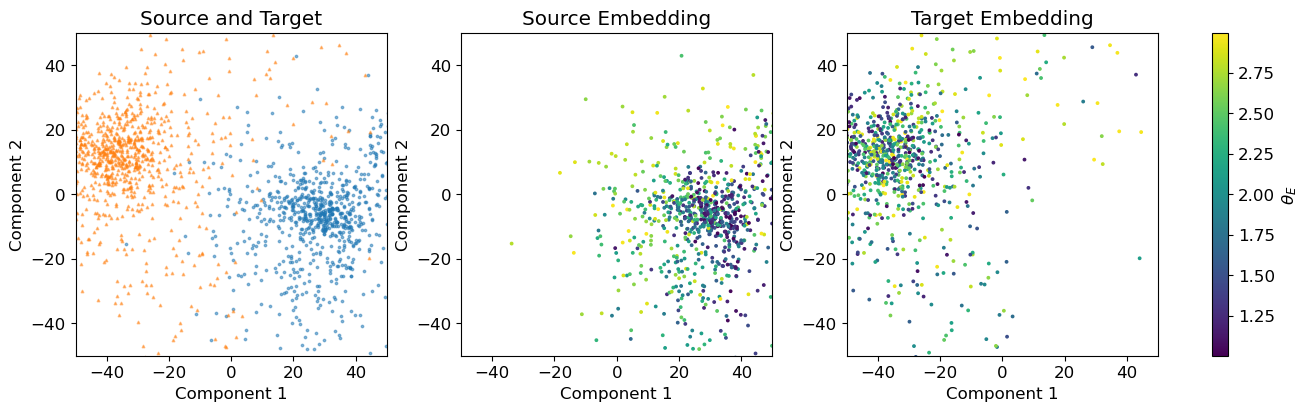

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [14]:
# Visualize isomaps 
plt.rcParams.update({'font.size': 12})
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

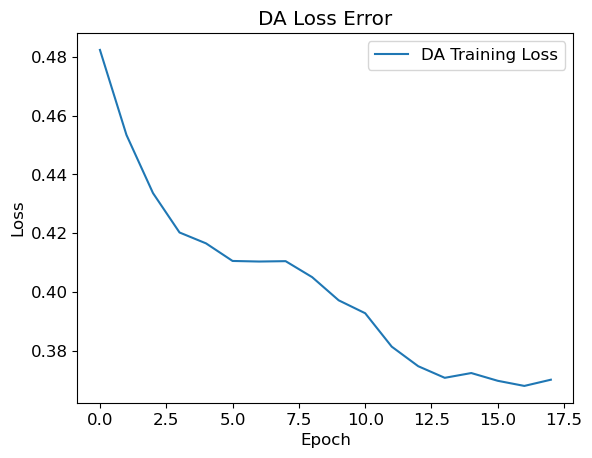

In [15]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.ylim(0.01, 0.2)

(0.0, 0.1)

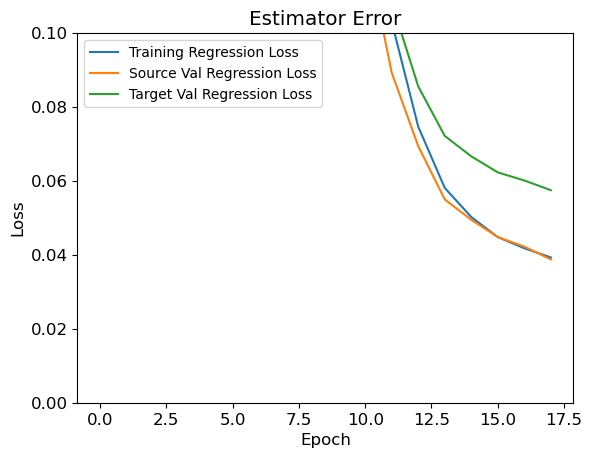

In [16]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(0, 0.10)

(-2.0, 2.0)

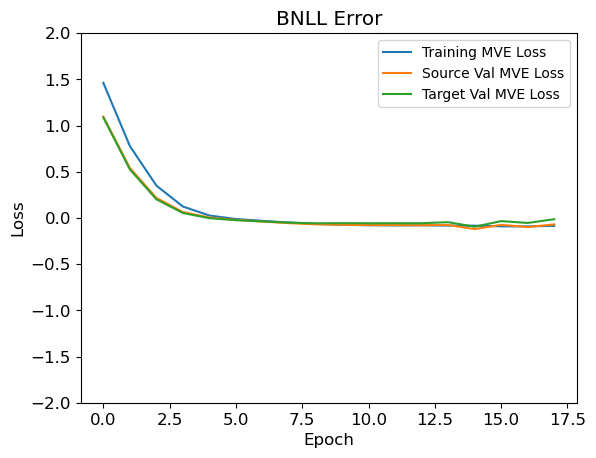

In [17]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-2, 2)

(0.7, 1.0)

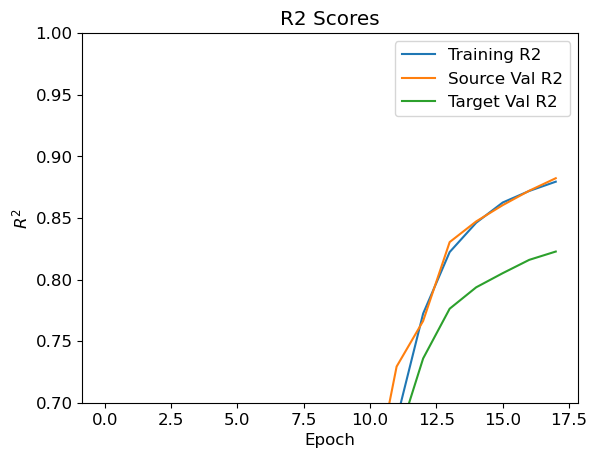

In [18]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.7, 1)

In [19]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.8744


Text(0.5, 1.0, 'MMD | Source | R2: 0.874')

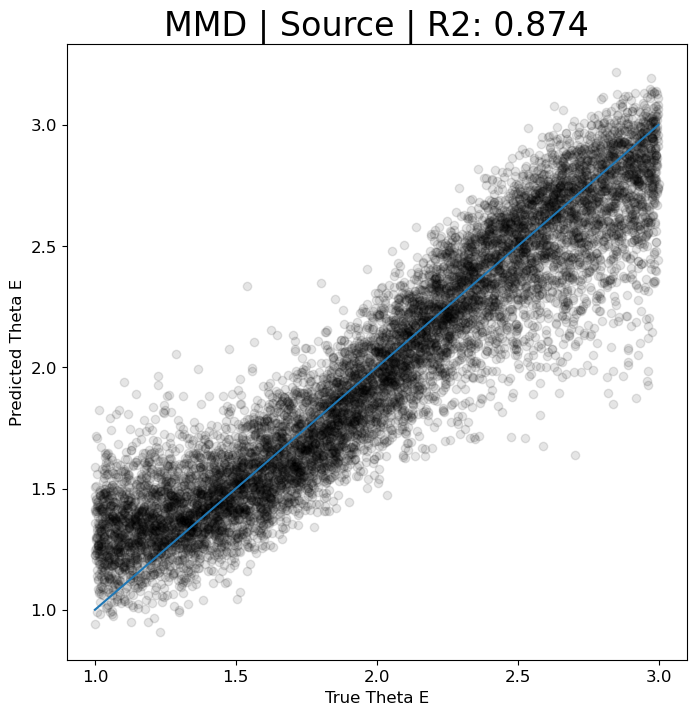

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.874')

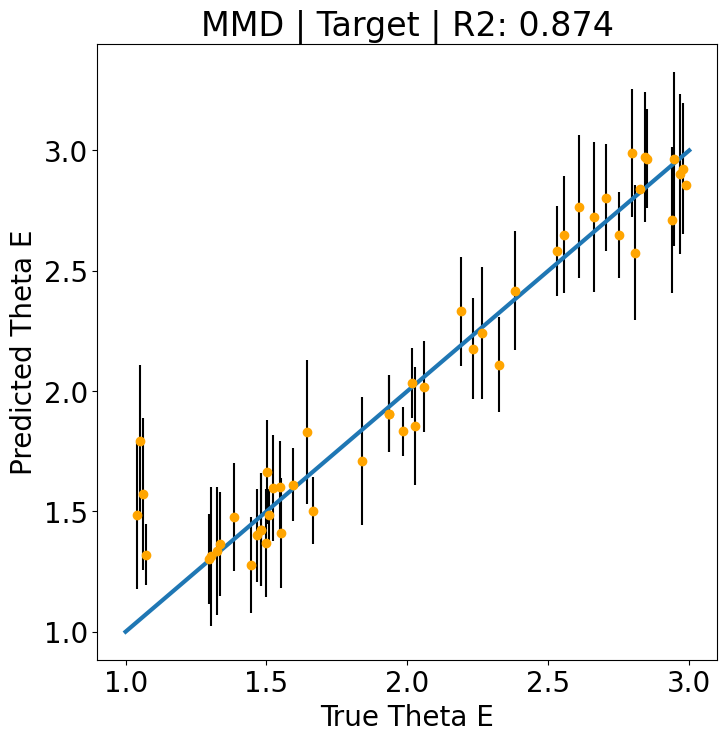

In [21]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_source)), 50)
plt.errorbar(true_source[idx], preds_source[idx], yerr = np.sqrt(var_preds_source[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: 0.964')

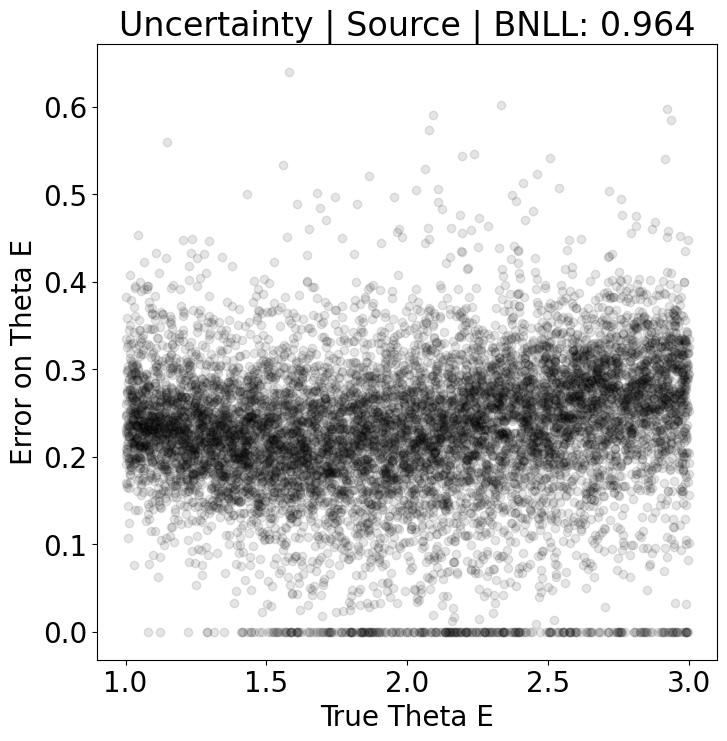

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [23]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.8148


Text(0.5, 1.0, 'MMD | Target | R2: 0.815')

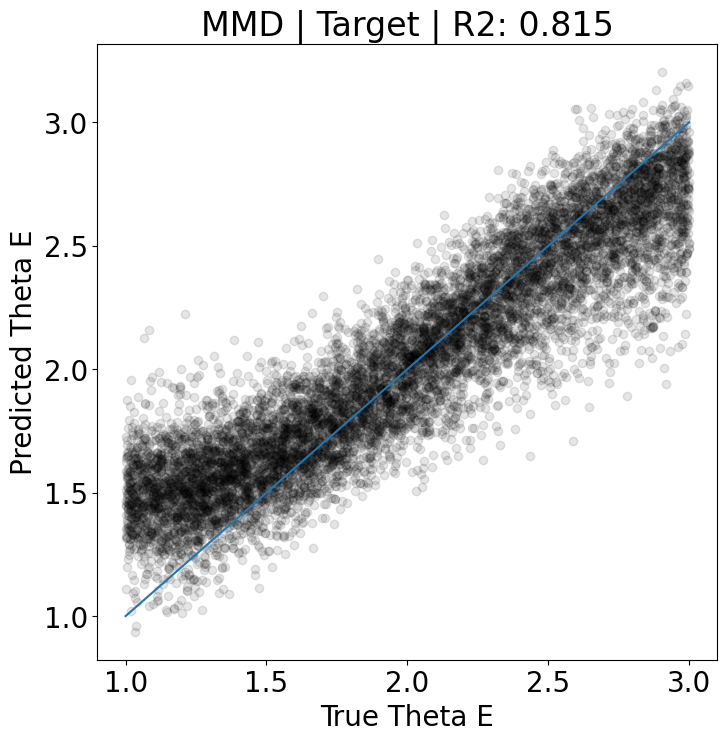

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.815')

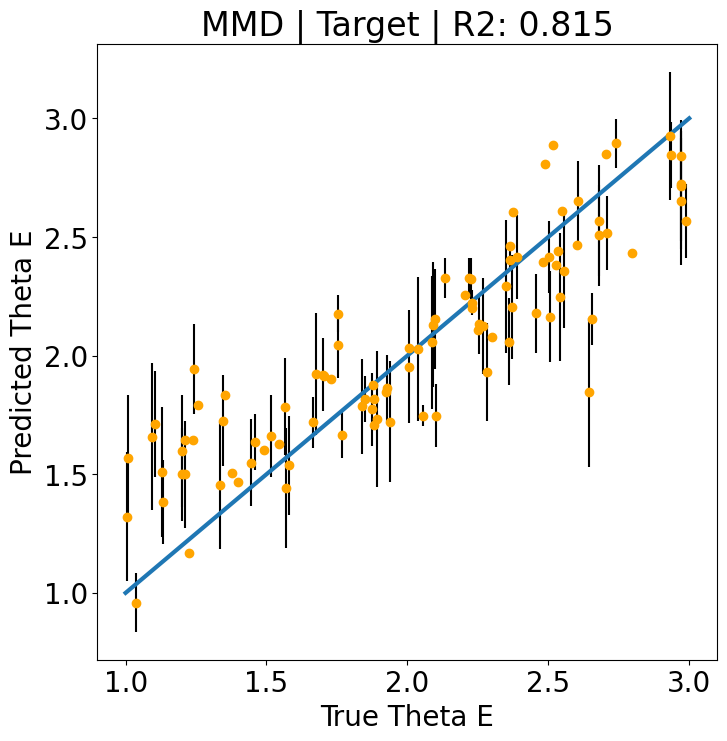

In [25]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: 18.878')

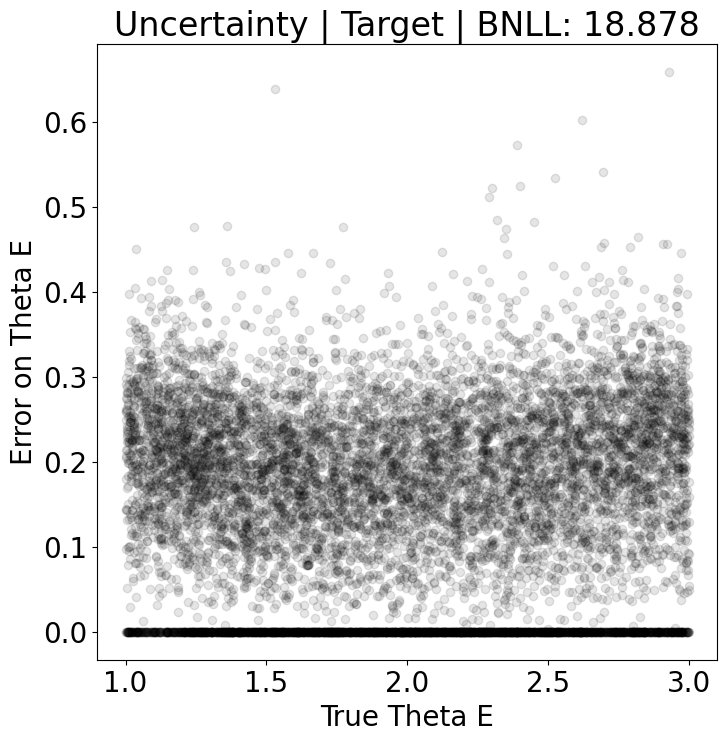

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [27]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

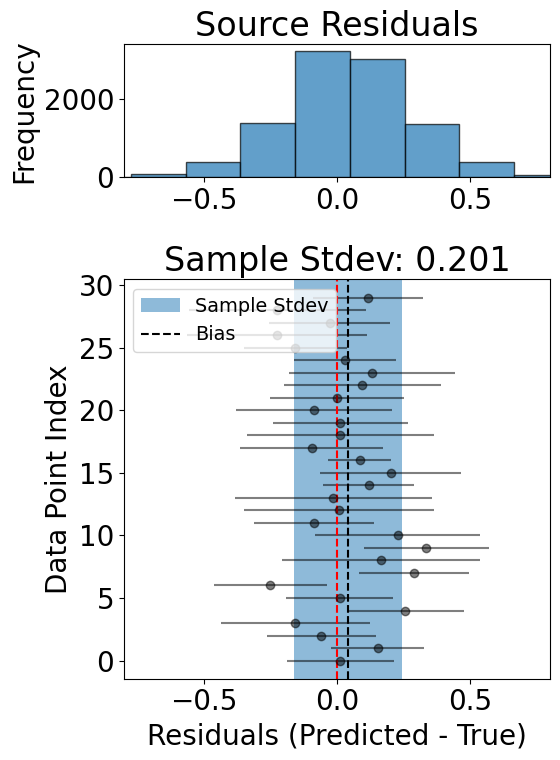

In [28]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')
ax_resid.sharex(ax_hist)


plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

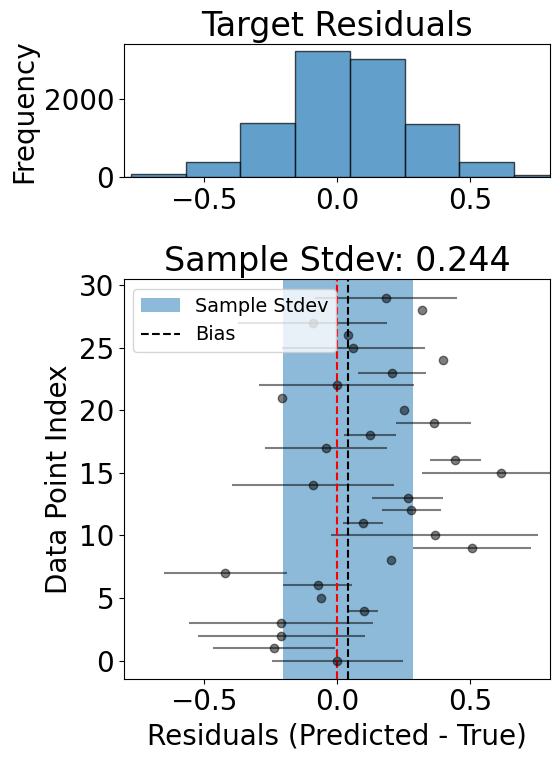

In [29]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')
ax_resid.sharex(ax_hist)
plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

0.24443301246874968


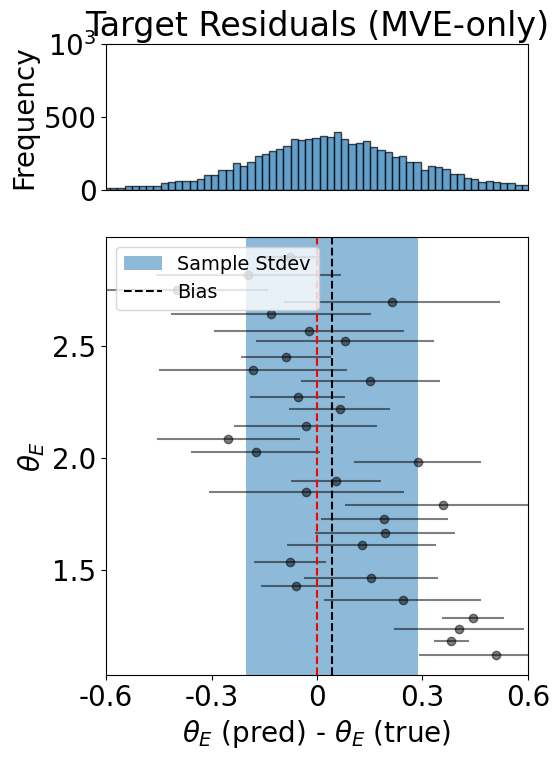

In [32]:
bins = np.linspace(1.1, 2.9, 60)
indices = np.digitize(true_target, bins) - 1 
ord_idx = np.array([np.random.choice(np.where((indices == k) & (var_preds_target > 0))[0], 1) for k in range(0, 60, 2)])
n_points = 30
rand_idx = ord_idx[:, 0]
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=100, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals (MVE-only)')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=true_target[rand_idx], xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel(r'$\theta_E$ (pred) - $\theta_E$ (true)')
ax_resid.set_ylabel(r'$\theta_E$')
#ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')
#ax_resid.sharex(ax_hist)
ax_hist.set_yticks([0, 500, 1000])
ax_resid.set_xticks([-0.6, -0.3, 0, 0.3, 0.6])
ax_resid.set_xticklabels([-0.6, -0.3, 0, 0.3, 0.6])
ax_hist.set_xticks([])
ax_hist.set_yticklabels([0, "500", "$10^3$"])
ax_hist.set_xlim(-0.6, 0.6)
ax_resid.set_xlim(-0.6, 0.6)
print(sv)

plt.tight_layout()
plt.savefig("target_resid_noDA.png", bbox_inches = 'tight', dpi = 400)